In [16]:
import os
import numpy as np
import pandas as pd
import os
import astropy.units as u
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
from astroquery.gaia import Gaia
import matplotlib.pyplot as plt
Gaia.MAIN_GAIA_TABLE = "gaiaedr3.gaia_source" # Select early Data Release 3
%matplotlib inline

In [17]:
def normalization(img: np.ndarray, shape: str, lock: bool):
    """
    :param img: CHW和HWC均可
    :param shape: 传入CHW或者HWC，输出同一形式
    :param lock: True时，三通道一起归一化，否则分通道归一化
    :return: 返回CHW或HWC
    """

    def compute(data: np.ndarray):
        h, w = data.shape
        data = data.reshape(-1)
        max = np.max(data)
        min = np.min(data)
        if max == min:
            return 65535
        else:
            norm_data = (data - min) / (max - min)
            return norm_data.reshape((h, w))

    if lock:
        original_shape = img.shape
        flatten = img.reshape(-1)
        normalized = (flatten - flatten.min()) / (flatten.max() - flatten.min())
        return normalized.reshape(original_shape)
    else:
        if shape == "CHW" or shape == "chw":
            g, r, z = img[0], img[1], img[2]
            norm_g, norm_r, norm_z = compute(g), compute(r), compute(z)
            if type(norm_g) == int or type(norm_r) == int or type(norm_z) == int:
                return 65535
            else:
                return np.array((norm_g, norm_r, norm_z))
        elif shape == "HWC" or shape == "hwc":
            g, r, z = img[:, :, 0], img[:, :, 1], img[:, :, 2]
            norm_g, norm_r, norm_z = compute(g), compute(r), compute(z)
            if type(norm_g) == int or type(norm_r) == int or type(norm_z) == int:
                return 65535
            else:
                return np.concatenate(
                    (norm_g.reshape(256, 256, 1), norm_r.reshape(256, 256, 1), norm_z.reshape(256, 256, 1)), axis=2)
        else:
            raise RuntimeError


def mtf(data: np.ndarray, m: float):
    """
    非线性变换
    :param data: 输入数据
    :param m: midtones值
    :return: 结果
    """
    return ((m - 1) * data) / ((2 * m - 1) * data - m)


def channel_cut(gray):
    highlight = 1.
    hist, bar = np.histogram(gray.reshape(-1), bins=65536)
    cdf = hist.cumsum()
    shadow_index = np.argwhere(cdf > 0.001 * gray.reshape(-1).shape[0])[0]
    shadow = bar[shadow_index]
    midtones = np.median(gray) - shadow
    gray[gray < shadow] = shadow
    gray[gray > highlight] = 1.
    gray = gray.reshape(-1)
    norm_data = (gray - gray.min()) / (gray.max() - gray.min())
    gray = norm_data.reshape((256, 256))
    median = np.median(mtf(gray, midtones))
    set_median = 1 / 8
    weight = median / set_median
    right_midtones = weight * midtones
    return mtf(gray, right_midtones)


def auto_scale(data: np.ndarray):
    g, r, z = channel_cut(data[0]), channel_cut(data[1]), channel_cut(data[2])
    img = np.array((g, r, z))
    img[img < 0] = 0
    img[img > 1] = 1.
    return img


def chw2hwc(img):
    ch1, ch2, ch3 = img[0], img[1], img[2]
    h, w = ch1.shape
    return np.concatenate((ch1.reshape(h, w, 1), ch2.reshape(h, w, 1), ch3.reshape(h, w, 1)), axis=2)


def hwc2chw(img):
    ch1, ch2, ch3 = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    return np.array((ch1, ch2, ch3))


def load_img(file):
    """
    加载图像，dat和fits均支持，不过仅支持CxHxW
    :param filename: 传入文件名，应当为CHW
    :return: 返回CHW的ndarray
    """
    if ".fits" in file:
        with fits.open(file) as hdul:
            return hdul[0].data.astype(np.float32)
    else:
        raise TypeError

In [25]:
class Star:
   def __init__(self, img, wcs, ra, dec):
       self.channels, self.height, self.width = img.shape
       self.kernel = 15
       # self.img = img[0].data.astype(np.float32)
       # self.wcs = WCS(img[0].header).sub(axes=2)
       self.img = img
       self.wcs = wcs
       self.ra = ra
       self.dec = dec
   def run(self):
       coord = SkyCoord(ra=self.ra, dec=self.dec, unit=(u.degree, u.degree), frame='icrs')   # 改坐标格式
       resolution = u.Quantity(0.262, u.arcsec)
       width = 256 * resolution
       height = 256 * resolution
       ans = Gaia.query_object_async(coordinate=coord, width=width, height=height)   # 查询gaia星表
       # print(ans['parallax'])
       a = pd.DataFrame({'ra': ans['ra'],'dec': ans['dec'],'mag':ans['phot_g_mean_mag']})
       icrs_poi = []
       for k in range(len(a)):
           icrs_poi.append([a.iloc[k].ra, a.iloc[k].dec])
       print(icrs_poi)
       pix_poi = self.wcs.all_world2pix(icrs_poi, 0)    # 将gaia查询结果转成像素值
       # print(pix_poi)
       # print(type(pix_poi))
       print(pix_poi)
       # print(poi)
       if not type(pix_poi) == list:
           pix_poi = pix_poi.astype(int)
           if pix_poi.shape[0] > 0:
               for j in range(pix_poi.shape[0]):
                   if not (pix_poi[j, 1] in range(int(self.height/2 - 10), int(self.height/2 + 10)) and pix_poi[j, 0] in range(int(self.height/2 - 10), int(self.height/2 + 10))):
                       star = self.img[:, pix_poi[j, 1] - self.kernel:pix_poi[j, 1] + self.kernel, pix_poi[j, 0] - self.kernel:pix_poi[j, 0] + self.kernel]
                       sub = star - np.median(star)
                       sub[sub < 0] = 0
                       sub[sub > 0] = 2
                       sub[sub == 0] = 1
                       sub[sub == 2] = 0
                       sub = sub.astype(int)
                       mask = sub[0] + sub[1] + sub[2]
                       mask[mask > 0] = 1
                       self.img[:, pix_poi[j, 1] - self.kernel:pix_poi[j, 1] + self.kernel, pix_poi[j, 0] - self.kernel:pix_poi[j, 0] + self.kernel] *= mask
               return self.img
       else:
           return self.img

INFO: Query finished. [astroquery.utils.tap.core]
[[220.6332242129409, 26.986075511232766], [220.64242453392072, 26.98870167069198], [220.64238315997238, 26.988838587808523]]
[[127.78613427 127.53639083]
 [ 15.13677482 163.62510828]
 [ 15.64349637 165.50637545]]


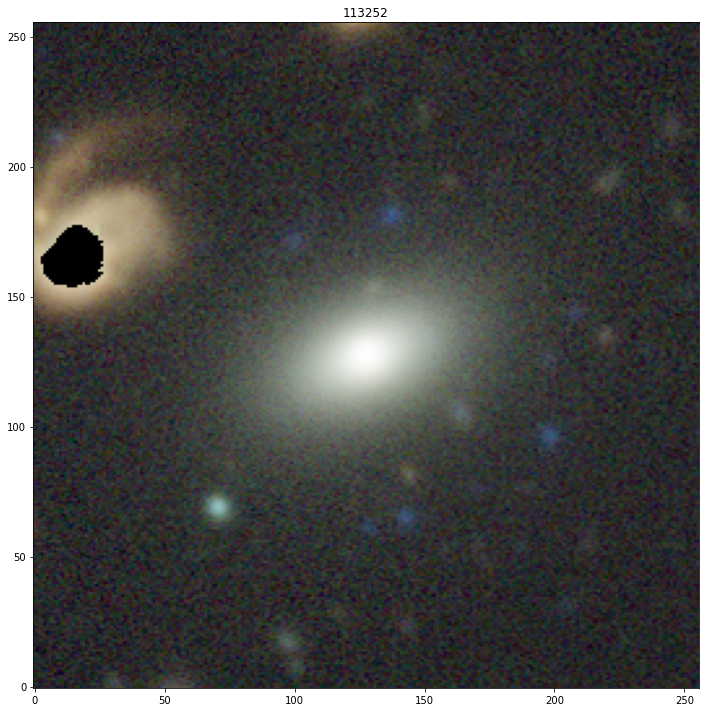

In [33]:
plt.figure(figsize=(10, 10))
# path = "/data/renhaoye/decals_2022/in_decals/dataset/testSet/7/"
import warnings
warnings.filterwarnings("ignore")
path = "/data/renhaoye/decals_2022/in_decals/fits/"
fits_files = os.listdir(path)
i = 113252
scaled = None
hdul = fits.open(path + fits_files[i])
img = normalization(hdul[0].data, shape="CHW", lock=False)
if not type(img) == int:
    img = normalization(img, shape="CHW", lock=True)  # 再做一次全通道归一化
    if not type(img) == int:
        scaled = auto_scale(img)    # 再做stf
        ra, dec = fits_files[i].split(".fits")[0].split("_")
        ra, dec = float(ra), float(dec)
        star = Star(scaled, WCS(hdul[0].header).sub(axes=2), ra, dec)
        masked = star.run()
        plt.imshow(chw2hwc(masked), origin="lower")
        plt.title(i)
        # plt.xticks([])
        # plt.yticks([])
hdul.close()
plt.tight_layout()
plt.show()

In [7]:
ans.pprint(max_lines=12, max_width=500)

NameError: name 'ans' is not defined